# Recommendation of tariffs.

The mobile network operator "Megaline" found out that many customers use archived tariffs. They want to build a system that can analyze customer behavior and offer users a new tariff: "Smart" or "Ultra". We need to build a model for the classification task that will select the appropriate tariff. We will build a model with the highest accuracy value, but not less than 0.75.

## Plan:
### 1. Reviewing of the data.
### 2. Preprocessing.
### 3. Training models.
### 4. Testing the model.
### 5. Checking the model for adequacy.
### 6. Overall conclusion.

## Description of data: 

calls - number of calls, 

minutes - total duration of calls in minutes, 

messages - number of SMS messages, 

mb_used - internet traffic consumed in MB, 

is_ultra - which tariff was used during the month ("Ultra" - 1, "Smart" - 0).

## 1. Reviewing of the data.

We will import libraries and tools.

In [217]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [183]:
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:,.2f}'.format

We will open the dataset.

In [184]:
url = 'https://code.s3.yandex.net/datasets/users_behavior.csv'
df = pd.read_csv(url)

In [185]:
df.head()

calls  minutes  messages   mb_used  is_ultra
0  40.00   311.90     83.00 19,915.42         0
1  85.00   516.75     56.00 22,696.96         0
2  77.00   467.66     86.00 21,060.45         0
3 106.00   745.53     81.00  8,437.39         1
4  66.00   418.74      1.00 14,502.75         0

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [187]:
print('Number of duplicates:', df.duplicated().sum())

Number of duplicates: 0


We will transform the data in the columns calls and messages from float to int, as the number of calls and messages are only integer data.

In [188]:
df['calls'] = df['calls'].astype(int)
df['messages'] = df['messages'].astype(int)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


In [190]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

In [191]:
df.head()

calls  minutes  messages   mb_used  is_ultra
0     40   311.90        83 19,915.42         0
1     85   516.75        56 22,696.96         0
2     77   467.66        86 21,060.45         0
3    106   745.53        81  8,437.39         1
4     66   418.74         1 14,502.75         0

In [192]:
df.describe()

calls  minutes  messages   mb_used  is_ultra
count 3,214.00 3,214.00  3,214.00  3,214.00  3,214.00
mean     63.04   438.21     38.28 17,207.67      0.31
std      33.24   234.57     36.15  7,570.97      0.46
min       0.00     0.00      0.00      0.00      0.00
25%      40.00   274.58      9.00 12,491.90      0.00
50%      62.00   430.60     30.00 16,943.24      0.00
75%      82.00   571.93     57.00 21,424.70      1.00
max     244.00 1,632.06    224.00 49,745.73      1.00

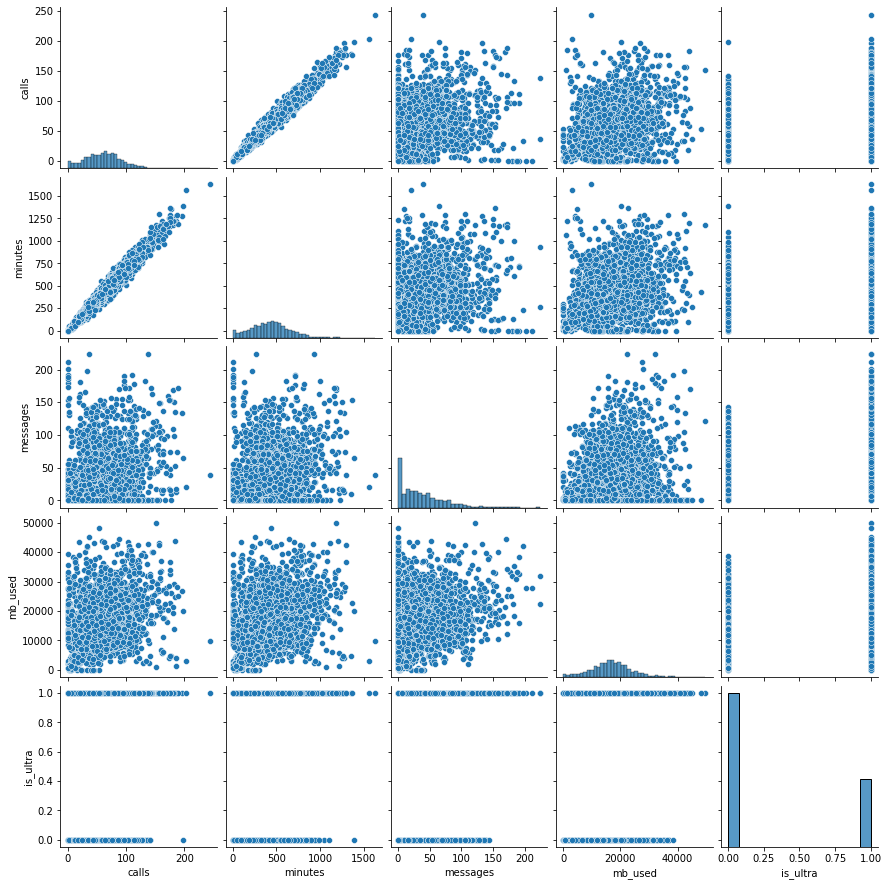

In [193]:
sns.pairplot(df)
plt.show()

We will take a closer look at the dependency of these parameters.

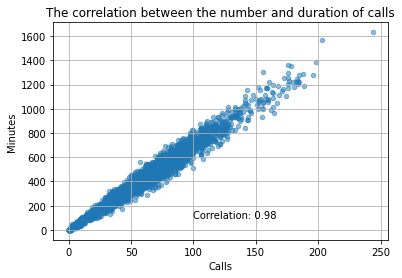

In [194]:
df.plot(x='calls', 
        y='minutes', 
        kind='scatter', 
        grid=True, 
        alpha=0.5) 
plt.text(100, 100, 'Correlation: ' + str(round(df['calls'].corr(df['minutes']), 2)))
plt.title('The correlation between the number and duration of calls')
plt.ylabel('Minutes')
plt.xlabel('Calls')
plt.show()

As we can see, there is a practical linear dependency with a correlation coefficient of 0.98. This circumstance will reduce the accuracy of the models. We will remove the calls column.

In [195]:
df = df.drop(['calls'], axis=1)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   minutes   3214 non-null   float64
 1   messages  3214 non-null   int64  
 2   mb_used   3214 non-null   float64
 3   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 100.6 KB


Conclusion: 

After examining the data, we see that the dataset consists of 5 columns and 3214 rows of data, with no duplicates, missing values, or errors in the headers. For logical display of data, the values of the columns calls and messages are converted to integer.

## 2. Preprocessing.

We will identify features and target features.

In [197]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [198]:
target.value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

As we can see, the target is not balanced.

We will split the dataframe into training, validation, and test sets.

In [199]:
features_train, features_part, target_train, target_part = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.40, 
                                                                            random_state=12345, 
                                                                            stratify=df['is_ultra'])

features_valid, features_test, target_valid, target_test = train_test_split(features_part, 
                                                                            target_part, 
                                                                            test_size=0.5, 
                                                                            random_state=12345)

We will look at the size of the samples.

In [200]:
print('features_train',features_train.shape, 
      'features_valid',features_valid.shape, 
      'features_test',features_test.shape, 
      'target_train',target_train.shape,  
      'target_valid',target_valid.shape, 
      'target_test',target_test.shape)


features_train (1928, 3) features_valid (643, 3) features_test (643, 3) target_train (1928,) target_valid (643,) target_test (643,)


## 3. Training models.

We will train a decision tree model.

In [201]:
best_model_dt = None
best_result_dt = 0
best_result_train_dt = 0
best_depth_dt = 0

for depth_dt in range(1, 40):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth_dt)
    model_dt.fit(features_train, target_train)
    result_train_dt = model_dt.score(features_train, target_train)
    result_dt = model_dt.score(features_valid, target_valid)
    
    if (result_dt > best_result_dt) and (result_train_dt > best_result_train_dt):
        best_model_dt = model_dt
        best_result_train_dt = result_train_dt
        best_result_dt = result_dt
        best_depth_dt = depth_dt

In [202]:
print('The accuracy of the best model on the validation set:', round(best_result_dt, 5))
print('The best value of the Depth:', best_depth_dt)

The accuracy of the best model on the validation set: 0.79938
The best value of the Depth: 9


We will train a random forest model.

In [203]:
best_model_rf = None
best_result_rf = 0
best_result_train_rf = 0
best_est_rf = 0
best_depth_rf = 0

for est_rf in range(1, 40):
    for depth_rf in range(1, 20):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est_rf, max_depth=depth_rf)
        model_rf.fit(features_train, target_train)
        result_train_rf = model_rf.score(features_train, target_train)
        result_rf = model_rf.score(features_valid, target_valid)
        
        if (result_rf > best_result_rf) and (result_train_rf > best_result_train_rf):
          best_model_rf = model_rf
          best_result_train_rf = result_train_rf
          best_result_rf = result_rf
          best_est_rf = est_rf
          best_depth_rf = depth_rf

In [204]:
print('The accuracy of the best model on the validation set:', round(best_result_rf, 5))  
print('The best value of the Est:', best_est_rf)
print('The best value of the Depth:', best_depth_rf)

The accuracy of the best model on the validation set: 0.84137
The best value of the Est: 36
The best value of the Depth: 12


We will train a logistic regression model.

In [205]:
model_lr =  LogisticRegression(random_state=12345)
model_lr.fit(features_train, target_train)
result_train_lr = model_lr.score(features_train, target_train)
predictions_lr = model_lr.predict(features_valid)
accuracy_lr = accuracy_score(target_valid, predictions_lr)

In [206]:
print('The accuracy of the model on the validation set:', round(accuracy_lr, 5))

The accuracy of the model on the validation set: 0.72162


Conclusion: 

As we can see, the accuracy threshold of 0.75 was passed by two models - a decision tree with the best accuracy on the validation set of 0.79938 at depth = 9, and a random forest model with the best accuracy on the validation set of 0.84137 at est = 36, depth = 12. 

The logistic regression model showed an accuracy on the validation set of 0.72162, which is below the threshold of 0.75.

## 4. Testing the model.

Based on the previously obtained data, we will test both models on the test sample.

We will test the decision tree model on the test sample.

In [207]:
predictions_dt = best_model_dt.predict(features_test)
accuracy_dt = accuracy_score(target_test, predictions_dt)

In [208]:
print('The accuracy of the model on the test set:', round(accuracy_dt, 5))

The accuracy of the model on the test set: 0.78694


We will test the random forest model on the test sample.

In [209]:
predictions_rf = best_model_rf.predict(features_test)
accuracy_rf = accuracy_score(target_test, predictions_rf)

In [210]:
print('The accuracy of the model on the test set:', round(accuracy_rf, 5))

The accuracy of the model on the test set: 0.80871


Conclusion: 

We can see that the decision tree and random forest models on the test sample show accuracy above the threshold value of 0.75.

We will test the models by retraining them on the combined training and validation sample to increase accuracy.

We will combine the training and validation samples.

In [211]:
features_train=pd.concat([features_train, features_valid])
target_train=pd.concat([target_train, target_valid])

We will retrain the models on the combined sample.

We will retrain the decision tree model and test it.

In [212]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=9)
model_dt.fit(features_train, target_train)
predictions_dt = best_model_dt.predict(features_test)
accuracy_dt = accuracy_score(target_test, predictions_dt)

In [213]:
print('The accuracy of the model on the test set:', round(accuracy_dt, 5))

The accuracy of the model on the test set: 0.78694


We will retrain the random forest model  and test it.

In [214]:
model_rf = RandomForestClassifier(random_state=12345, n_estimators=36, max_depth=12)
model_rf.fit(features_train, target_train)
predictions_rf = best_model_rf.predict(features_test)
accuracy_rf = accuracy_score(target_test, predictions_rf)

In [215]:
print('The accuracy of the model on the test set:', round(accuracy_rf, 5))

The accuracy of the model on the test set: 0.80871


Conclusion: As we can see, the accuracy of the decision tree and random forest models after retraining on the combined sample of training and validation on the test sample has not changed.

## 5. Checking the model for adequacy.

To check the models for adequacy, we will compare the accuracy of the simplest (dummy) model, which always predicts the most frequent class, with the current trained models on the test sample.

In [220]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(features_test, target_test)
predictions_dc = dummy_clf.predict(features_test)
dummy_clf_acc_test = accuracy_score(target_test, predictions_rf)
print('The accuracy of the dummy model on the test sample:', round(dummy_clf_acc_test, 5))

if accuracy_dt >= dummy_clf_acc_test:
  print('The decision tree model on the test sample is adequate')
else:
  print('The decision tree model on the test sample is not adequate')
  
if accuracy_rf >= dummy_clf_acc_test:
  print('The random forest model on the test sample is adequate')
else:
  print('The random forest model on the test sample is not adequate')  

The accuracy of the dummy model on the test sample: 0.80871
The decision tree model on the test sample is not adequate
The random forest model on the test sample is adequate


Conclusion: 

As we can see, the dummy model makes mistakes on the test sample by 20%, while the random forest model passed the adequacy check. The model that will select the appropriate tariff for this dataset is the random forest model with global parameters est = 36 and depth = 12.

## 6. Overall conclusion.

1. No missing data, anomalies, or errors were identified when examining the dataset.
2. Data in the calls and messages columns were transformed from float to int, as only integer data is available for the number of calls and messages.
3. An additional analysis of the data revealed a linear relationship between the parameters of the number of calls and minutes of conversation, with a correlation coefficient of 0.98. The calls column was excluded from the dataframe.
4. A target feature imbalance was identified.
5. The data was divided into 60% training, 20% validation, and 20% test samples, with stratification by the target feature.
6. Models were built and a precision threshold of 0.75 was passed by two models - a decision tree with the best accuracy on the validation sample of 0.79938 at depth = 9, and a random forest model with the best accuracy on the validation sample of 0.84137 at est = 36, depth = 12. The logistic regression model showed an accuracy of 0.72162 on the validation sample, which is below the threshold of 0.75.
7. When checking the remaining models on the test sample, we see that the decision tree and random forest models show an accuracy higher than the threshold of 0.75.
8. Additional iterations of model overfitting on the combined sample (validation + training sample) showed that the accuracy of the models on the training sample did not change.
9. To check the adequacy of the models, a comparison was made with the simplest (dummy) model, which always predicts the most frequent class with the current trained models. Only the random forest model passed the adequacy check.
10. The model that will select the appropriate tariff for this dataset is the random forest model with global parameters est = 36 and depth = 12.